# Using the Detector class

Welcome to the Demo notebook, in this notebook we will go over the functions of the detector class and how to use it.  
After installing the repository using `pip` as stated in the [installation guide](../INSTALL.md) you can start this notebook


In [1]:
# start by importing the necessary packages
import cv2
import os
import matplotlib.pyplot as plt
from demo_functions import visualise_flakes, remove_vignette
import json

# import the detector
from GMMDetector import MaterialDetector

IMAGE_DIR = "images"

## Defining the parameters

The parameters of the model can either be read directly from a `.json` file or be defined in the code itself, as shown below.  
The parameters always need to following keys:

| Key               | Description                                                        |
| ----------------- | ------------------------------------------------------------------ |
| `contrast`          | The mean contrast of the layer to be detected                      |
| `covariance_matrix` | The standard deviation of the contrast of the layer to be detected |

The defined paramters are the parameters from the `GMMDetector/trained_parameters/Graphene_GMM.json` and thus usable for graphene on 90nm SiO2.


In [2]:
contrast_dict = json.load(open("../contrastDictDir/Graphene_GMM.json", "r"))
# contrast_dict = {
#     "1": {
#         "contrast": {"b": -0.071, "g": -0.14, "r": -0.137},
#         "covariance_matrix": [
#             [0.00043690708813418295, 0.00013442550316341518, 3.640871553385172e-05],
#             [0.00013442550316341518, 0.00023107833499992487, 9.354030315496938e-05],
#             [3.640871553385172e-05, 9.354030315496936e-05, 0.0003320244165912582],
#         ],
#     },
#     "2": {
#         "contrast": {"b": -0.152, "g": -0.264, "r": -0.248},
#         "covariance_matrix": [
#             [0.0008328732295338676, 0.00025254658263370265, -0.00011751135771427775],
#             [0.00025254658263370265, 0.0002369906495868485, 2.030565474167504e-05],
#             [-0.00011751135771427775, 2.030565474167504e-05, 0.00031832333867950097],
#         ],
#     },
#     "3": {
#         "contrast": {"b": -0.216, "g": -0.368, "r": -0.347},
#         "covariance_matrix": [
#             [0.0013438145132320882, 0.0003876553710589909, -0.00017056175302890137],
#             [0.0003876553710589909, 0.00027824710350493256, 1.567135606074001e-06],
#             [-0.00017056175302890137, 1.5671356060739976e-06, 0.0003016258829573738],
#         ],
#     },
#     "4": {
#         "contrast": {"b": -0.272, "g": -0.465, "r": -0.436},
#         "covariance_matrix": [
#             [0.0010399285512173939, 0.00038128261246451735, 4.529938289991867e-05],
#             [0.00038128261246451735, 0.0002952529548842852, 4.883854391652727e-05],
#             [4.529938289991866e-05, 4.883854391652727e-05, 0.0002183833746245863],
#         ],
#     },
# }

# Its also possible to load the contrast_dict from a json file
# contrast_dict = json.load(open("../GMMDetector/trained_parameters/Graphene_GMM.json", "r"))

## Instantiate the model

The model takes a few different parameters, these are described in the following table:

| Parameter                      | Description                                                                                                          |
| ------------------------------ | -------------------------------------------------------------------------------------------------------------------- |
| `contrast_dict`                | The contrast dictionary of the material, Keys are the layer names, values are the contrast and the covariance matrix |
| `size_threshold`               | The minimal size of a flake in pixels.                                                                               |
| `standard_deviation_threshold` | The maximal standard deviation threshold for the GMM of the contrast in a flake.                                     |
| `used_channels`                | The used channels for the detection, this is "BGR" by default for all channels                                       |
| `false_positive_detector_path` | The path to the false positive detector model.                                                                       |


In [3]:
model = MaterialDetector(
    contrast_dict=contrast_dict,
    size_threshold=500,
    standard_deviation_threshold=5,
    used_channels="BGR",
)

In [4]:
video = cv2.VideoCapture(0, cv2.CAP_DSHOW)

## Start Detecting flakes

The model expects an image in the BGR format and __without__ Vignetting, the Demo images have their vigenetting removed.  
If you want to use your own images, make sure to remove the vignetting first by recording a flatfield image and calling the `remove_vigentte` function. 
   
When reading image using OpenCV, the image is read in BGR format.  
If you are using any other library to read the image, make sure to convert it to BGR format before passing it to the model.

The Model returns a list of `Flakes`, the `Flakes` are saved in a class called [Flake](../GMMDetector/structures/FlakeClass.py).
This `Flake` class has the following attributes:

| Attribute                    | Description                                                                                        |
| ---------------------------- | -------------------------------------------------------------------------------------------------- |
| `mask`                       | The mask of the flake, a 2D array with 1s and 0s indicating the flake and background respectively. |
| `thickness`                  | The name of the layer the flake is from.                                                           |
| `size`                       | The size of the flake in pixels.                                                                   |
| `mean_contrast`              | The mean contrast of the flake in BGR as defined in "https://arxiv.org/abs/2306.14845".            |
| `center`                     | The center of the flake in pixels relative to the top left corner of the image.                    |
| `max_sidelength`             | The maximum sidelength of the flake in pixels, measured using a rotated bounding box.              |
| `min_sidelength`             | The minimum sidelength of the flake in pixels, measured using a rotated bounding box.              |
| `false_positive_probability` | The probability of the flake being a false positive. This is the same a $1 - \text{Confidence}$                                               |
| `entropy`                    | The Shannon entropy of the flake.                                                                  |


In [5]:
# Set the confidence threshold to 0 to see all the flakes
CONFIDENCE_THRESHOLD = 0.5

# read the flatfield image if necessary
# flatfield = cv2.imread("flatfield.png")


# image = cv2.imread('0-3-camera.png')



# Remove vignette if necessary
# image = remove_vignette(image, flatfield)

# The model itself can also be called directly
# flakes = model(flakes)



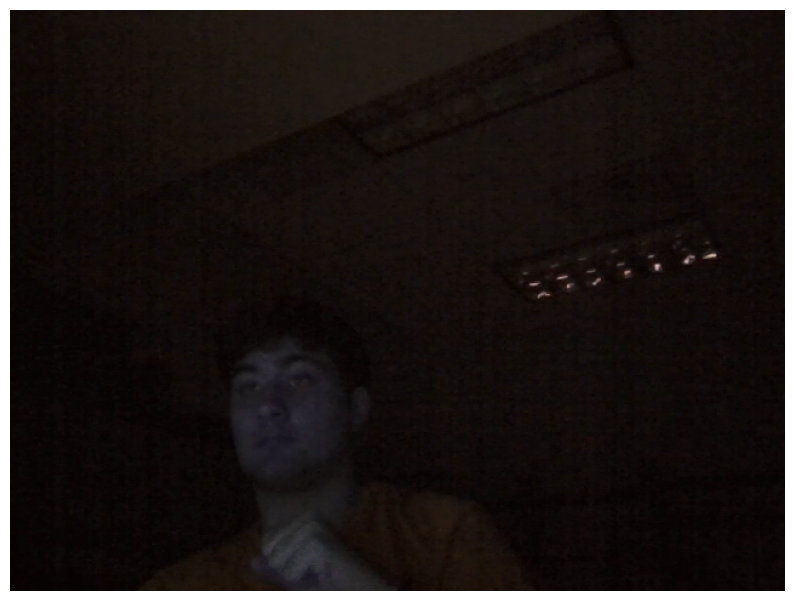

In [20]:
ret, image = video.read()

plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis("off")
plt.show()

In [21]:
flakes = model.detect_flakes(image)


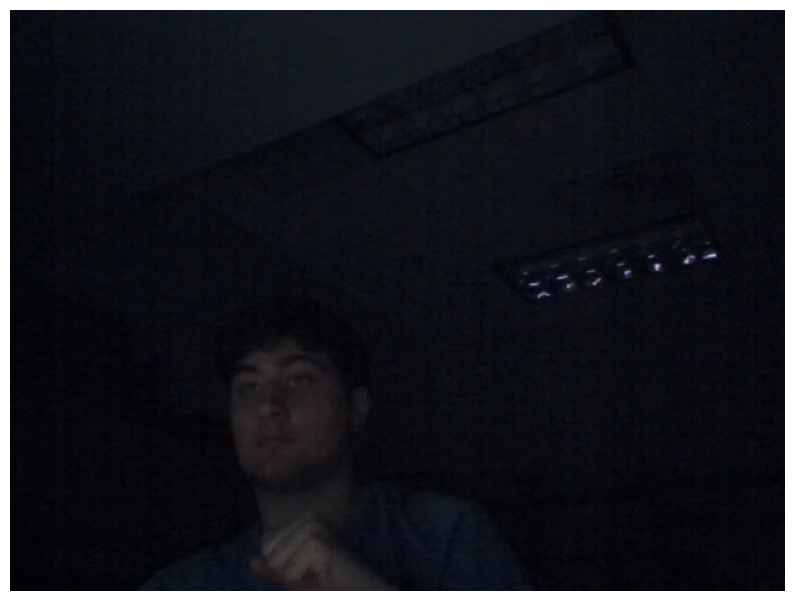

In [22]:
image = visualise_flakes(
    flakes,
    image,
    confidence_threshold=CONFIDENCE_THRESHOLD,
)
plt.figure(figsize=(10, 10))
plt.imshow(image[:, :, ::-1])
plt.axis("off")
plt.show()